<a href="https://colab.research.google.com/github/Sanchez-JC/Colab-Notebooks/blob/main/Poisson_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
import requests
exec(requests.get("https://raw.githubusercontent.com/Sanchez-JC/Functions_py/refs/heads/main/progress_bar.py").text)

In [69]:
#@title Creación de malla
Npx = 100
Npy = 100

xa = 0
xb = 2
hx = (xb-xa)/(Npx-1)
ya = 0
yb = 1
hy = (yb-ya)/(Npy-1)

x = [xa + hx * i for i in range(Npx)]
y = [ya + hy * j for j in range(Npy)]

In [70]:
#@title Variables
#VARIABLES AUXILIARES

def SOURCE(x, y):
  return 0

tol = 10e-5
err_local = 0
err_max = 0
it_max = int(1e6)
cte_1 = 0.5*pow(hy,2)/(pow(hx,2)+pow(hy,2))
cte_2 = 0.5*pow(hx,2)/(pow(hx,2)+pow(hy,2))
cte_3 = 0.5*pow(hx*hy,2)/(pow(hx,2)+pow(hy,2))

phi = np.zeros((Npx, Npy))
phi_old = np.zeros((Npx, Npy))

progress_bar = progress_bar

In [71]:
#@title Condiciones de frontera

for j in range(Npy):
  phi[0][j] = 0

for j in range(Npy):
  phi[-1][j] = 0

for i in range(Npx):
  phi[i][0] = 0

for i in range(Npx):
  phi[i][-1] = 0

In [72]:
#@title Bucle principal (Base)
def main():

  for it in range(it_max):

    for i in range(Npx):  #Guardar solución previa
      for j in range(Npy):
        phi_old[i][j] = phi[i][j]

    for i in range(1, Npx-1): #Calcula nueva solución excepto en la frontera
      for j in range(1, Npy-1):
        if (0.95 <= x[i] <= 1.05) and (0 < y[j] < 0.4):
          phi[i][j] = -1
        elif (0.95 <= x[i] <= 1.05) and (0.6 < y[j] < 1):
          phi[i][j] = -1
        else:
          phi[i][j] = cte_1*(phi[i+1][j]+phi[i-1][j]) + cte_2*(phi[i][j+1]+phi[i][j-1]) - cte_3*SOURCE(x[i],y[j])

    err_max = 0
    for i in range(1, Npx-1): #
      for j in range(1, Npy-1):
        err_local = abs(phi[i][j] - phi_old[i][j])
        if err_local > err_max:
          err_max = err_local
    if err_max < tol:
      progress_bar(tol, err_max)
      print("")
      print("Solución encontrada en ", it, " iteraciones")
      break

    if it % 100 == 0:
      progress_bar(tol, err_max)

  return

main()

[==================================================] 100.1%
Solución encontrada en  1210  iteraciones


In [64]:
#@title Bucle principal (optimizado)
def main():
    # Convertir a arrays numpy para operaciones vectorizadas
    x_arr = np.array(x)
    y_arr = np.array(y)

    # Precalcular máscaras para las condiciones especiales
    mask_condition1 = (x_arr[:, None] >= 0.95) & (x_arr[:, None] <= 1.05) & (y_arr[None, :] > 0) & (y_arr[None, :] < 0.4)
    mask_condition2 = (x_arr[:, None] >= 0.95) & (x_arr[:, None] <= 1.05) & (y_arr[None, :] > 0.6) & (y_arr[None, :] < 1)
    special_mask = mask_condition1 | mask_condition2

    # Índices internos (excluyendo bordes)
    i_idx = slice(1, Npx-1)
    j_idx = slice(1, Npy-1)

    for it in range(it_max):
        # Guardar solución previa (solo la parte interna que cambia)
        phi_old[i_idx, j_idx] = phi[i_idx, j_idx]

        # Calcular nuevo valor para puntos internos
        new_phi = cte_1 * (phi[2:, 1:-1] + phi[:-2, 1:-1]) + \
                 cte_2 * (phi[1:-1, 2:] + phi[1:-1, :-2]) - \
                 cte_3 * SOURCE(x_arr[1:-1, None], y_arr[None, 1:-1])

        # Aplicar condiciones especiales
        phi[1:-1, 1:-1] = np.where(special_mask[1:-1, 1:-1], -1, new_phi)

        # Calcular error máximo (solo en puntos internos)
        err_max = np.max(np.abs(phi[1:-1, 1:-1] - phi_old[1:-1, 1:-1]))

        if err_max < tol:
          progress_bar(tol, err_max)
          print("")
          print(f"Solución encontrada en {it} iteraciones")
          break

        if it % 100 == 0:
            progress_bar(tol, err_max)

    return

main()

[==================================================] 100.2%
Solución encontrada en 801 iteraciones


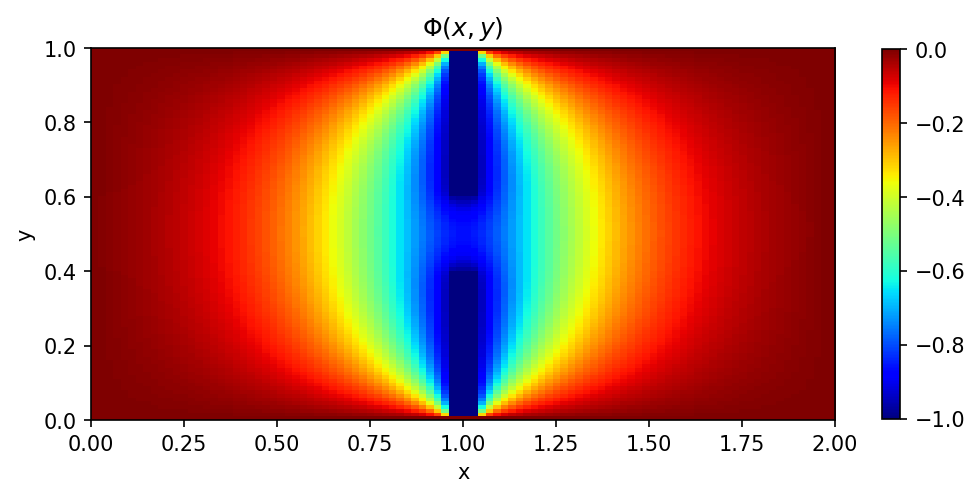

In [73]:
#@title Graficar
plt.figure(dpi = 150, figsize=(8, 4))
plt.imshow(np.rot90(phi, k=-1), extent=[np.min(x), np.max(x), np.min(y), np.max(y)], origin='lower', cmap='jet')
cbar = plt.colorbar(shrink=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'$\Phi (x, y)$')
plt.show()